In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import activations

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
# for 2nd attempt
from keras.callbacks import EarlyStopping

import keras.backend as K

Using TensorFlow backend.


In [2]:
# let's choose a simple 1->1 function to train
def f(x):
    return 10*np.sin(10*x)+(x-3)*(x+2)*(x-1/2)+80*np.exp(-(x-2)**2/0.1)

In [3]:
# evaluate some data points
datasize = 5000
datapoints = np.random.uniform(low=-5, high=5, size=(datasize,))
datavalues = np.array(list(map(f, datapoints)))
data = np.transpose([datapoints,datavalues])
# instead of random.uniform one could have generated a set of sequential points
# using np.arange(-2,2,<step size>), does it affect the performance?

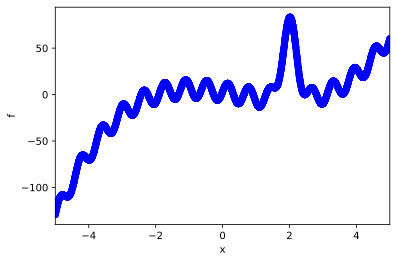

In [4]:
# plot the data points to see how they are distributed
plt.plot(datapoints, datavalues, 'bo')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

In [5]:
# use Mean Squared Error (MSE) for the loss function
def MSE(y_pred,y_true):
    return K.mean(K.square(y_pred - y_true))

In [6]:
## split into testing and training sets
print(len(data))
split = int(len(data)*80/100)

5000


In [7]:
# make sure all data is positive
def process_data(data):
    data_in_array = data[:,0]
    #data_in_ave = np.ave(data_in_array)
    #data_in_max = np.max(data_in_array)
    #data_in_min = np.min(data_in_array)
    #data_in_std = np.std(data_in_array)
    
    data_out_array = data[:,1]
    #data_out_ave = np.ave(data_out_array)
    data_out_max = np.max(data_out_array)
    data_out_min = np.min(data_out_array)
    #data_out_std = np.std(data_out_array)
    
    data_out_array = (data_out_array-data_out_min)/(data_out_max-data_out_min)
    
    data_processed = np.transpose([data_in_array,data_out_array])
    return data_processed, data_out_min, data_out_max

def unprocess_prediction(values, ymin, ymax):
    return values*(ymax-ymin) + ymin

In [8]:
### taken from stackoverflow
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [9]:
# Initialise model
model = Sequential()
## input layer
model.add(Dense(1, input_dim=1))
model.add(Activation(activations.sigmoid))
## hidden layers
model.add(Dense(16))
model.add(Activation(activations.sigmoid))
model.add(Dense(32))
model.add(Activation(activations.sigmoid))
model.add(Dense(16))
model.add(Activation(activations.sigmoid))
## output layer
model.add(Dense(1))
model.add(Activation(activations.sigmoid))

# Compile model
model.compile(
    optimizer = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss=MSE)

In [10]:
data_processed, ymin, ymax = process_data(data)
print(ymin, ymax)

-129.27171144904582 83.46663179559737


[1.29713663 0.03683708]
[1.29713663 0.60782907]


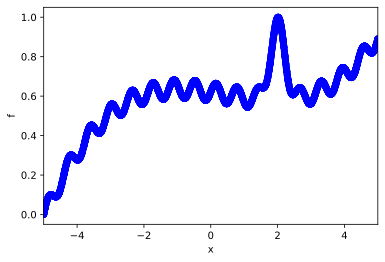

In [11]:
print(data[0])
print(data_processed[0])

plt.plot(data_processed[:,0], data_processed[:,1], 'bo')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

In [12]:
ES = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=0,
    restore_best_weights=True)

model.fit(
    data_processed[0:split,0],
    data_processed[0:split,1],
    epochs=10000,
    validation_data=(data_processed[split:,0], data_processed[split:,1]),
    callbacks=[SelectiveProgbarLogger(verbose = 1, epoch_interval = 300)],
    batch_size=512,
    verbose=0
)

Epoch 1/10000
4000/4000 [==============================] - 1s 255us/sample - loss: 0.0655 - val_loss: 0.0382
Epoch 301/10000
4000/4000 [==============================] - 0s 13us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 601/10000
4000/4000 [==============================] - 0s 11us/sample - loss: 9.5982e-04 - val_loss: 9.5686e-04
Epoch 901/10000
4000/4000 [==============================] - 0s 11us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 1201/10000
4000/4000 [==============================] - 0s 11us/sample - loss: 7.9378e-04 - val_loss: 7.4115e-04
Epoch 1501/10000
4000/4000 [==============================] - 0s 11us/sample - loss: 6.8164e-04 - val_loss: 6.7533e-04
Epoch 1801/10000
4000/4000 [==============================] - 0s 11us/sample - loss: 5.7364e-04 - val_loss: 6.1034e-04
Epoch 2101/10000
4000/4000 [==============================] - 0s 10us/sample - loss: 5.3332e-04 - val_loss: 5.1575e-04
Epoch 2401/10000
4000/4000 [==============================] - 0s 11us/sample 

In [13]:
datapoints2 = np.random.uniform(low=-5, high=5, size=(1000,))
datavalues2 = np.array(list(map(f, datapoints2)))
valuespred = model.predict(datapoints2)

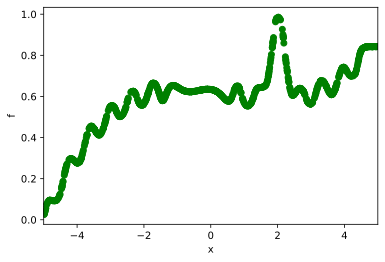

In [14]:
plt.plot(datapoints2, valuespred, 'go')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

In [15]:
valuespred_un = unprocess_prediction(valuespred, ymin, ymax)

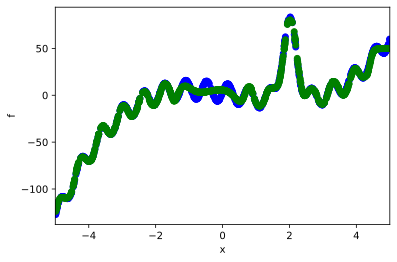

In [16]:
plt.plot(datapoints2, datavalues2, 'bo')
plt.plot(datapoints2, valuespred_un, 'go')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

## Exercises ##

1) Edit the code to create an arbitrary archictecture from a list of layer depths. How does the fit depend on the architecture?

2) Change the activation function used in the nodes to tanh, what changes in the output? Do you need to change the normalisation?

3) Can we change the loss function to prefer certain regions or features?

4) Vary the number of input data points. Is there an optimal number?

5) Using the template for early stopping try to optimise the number of epochs needed by the network

https://keras.io/api/callbacks/early_stopping/

6) Split the input and output data set according to random shuffle rather than a slice, do you see any affect?